In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
import scipy as sp
from matplotlib import pyplot as plt
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [4]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments'

Useful function for plot the dictionary

In [5]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set all the parameters for the anomaly detection

In [6]:
# patch size (tha patch is square)
p = 15

# number of patches in the training set for dictionary learning
npatch_dictionary = 10000

# number of patches to estimate the confidence region
npatch_region = 1000

# parameters for the dictionary learning using the KSVD
niter_dl = 10
natom = int(np.round(p**2*1.5))
L = 4

# regularization parameters for the l1 sparse coding
lmbda = 0.18

Construct the training and validation sets
------------------------------------------

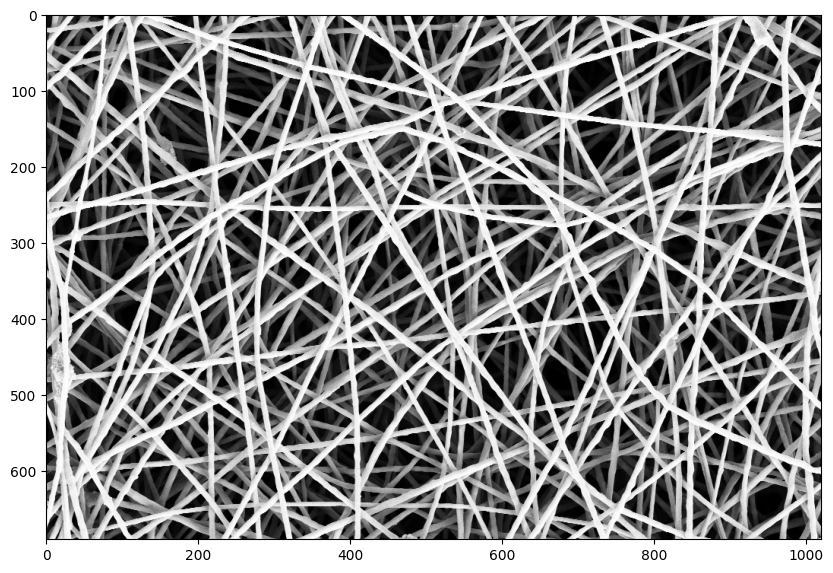

In [7]:
# load the training image and rescale it in [0,1]
img = imread(f'{rootfolder}/data/img_normal.png') / 255
imsz = img.shape
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

In [8]:
# extract random patches from the image and store them in a matrices S, V
# we need a train set which contain images with no anomalies
S = np.zeros((p**2, npatch_dictionary))
for i in range(npatch_dictionary):
  coord_x = np.random.randint(0, imsz[0] - p)
  coord_y = np.random.randint(0, imsz[1] - p)
  patch = img[coord_x: coord_x + p, coord_y: coord_y + p]
  S[:, i] = patch.flatten()

# extract new set V of normal patches
V = np.zeros((p**2, npatch_region))
for i in range(npatch_region):
  while True:
    coord_x = np.random.randint(0, imsz[0] - p)
    coord_y = np.random.randint(0, imsz[1] - p)
    patch = img[coord_x: coord_x + p, coord_y: coord_y + p]
    if not np.any(np.all(S.T == patch.flatten(), axis=1)):
      V[:, i] = patch.flatten()
      break

In [9]:
S.shape, V.shape

((225, 10000), (225, 1000))

Dictionary Learning
-------------------
Perform preprocessing on the patches in $S$

In [10]:
# PREPROCESSING: exclude black patches from S
v = np.median(S, axis=0)
S = S[:,v > 0.06]

In [11]:
# PREPROCESSING: remove the mean from each patch
S = S - np.mean(S, axis=0)

In [12]:
S.shape

(225, 9478)

Perform dictionary learning via KSVD or MOD

In [13]:
def IRLS(s, D, lmbda, x0=None):
  if x0 is None:
    x0 = np.zeros(D.shape[1])
  delta = 1e-6
  max_iter = 20
  distanceX = 1e10
  toll_x = 1e-3

  x = x0
  cnt = 0
  while cnt < max_iter or distanceX > toll_x:
    W = np.diag(1 / (np.abs(x) + delta))
    x_current = np.linalg.solve((lmbda*W) + (D.T @ D)  , (D.T @ s))
    distanceX = np.linalg.norm(x_current - x, ord=2)
    x = x_current
    cnt = cnt + 1
  return x

In [14]:
def MOD_dictionary_learning(S, niter, lmbda, natom ,D0=None):
  if D0 is None:
    D0 = np.random.randn(S.shape[0], natom)

  # normalization of each column of D
  D = D0 - D0.mean(axis=0)
  D /= np.linalg.norm(D, axis=0, ord=2)

  # initialize a matrix for the coefficients of all the patches
  X = D.T @ S

  # main loop
  for iter in range(niter):

    # perform the sparse coding for all the patches in S
    for n in range(npatch_dictionary):
        s = S[:, n]
        x = IRLS(s, D, lmbda)
        X[:, n] = x

    # MOD update
    # D = S @ X.T @ np.linalg.inv(X @ X.T)
    # or just solve the gradient descent step
    D = D - np.matmul((lmbda * (np.matmul(D,X) - S)), X.T)

    # normalize the column
    D /= np.linalg.norm(D, axis=0, ord=2)

  return D

In [15]:
#D = MOD_dictionary_learning(S, niter_dl, lmbda, natom)

# or load a precomputed dictionary
D = loadmat(f'{rootfolder}/data/dict_anom_det.mat')['D']

Show the learned dictionary

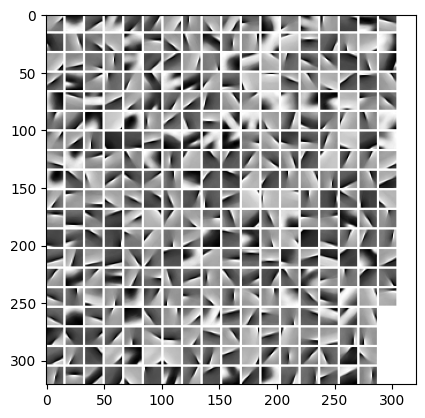

In [16]:
img_dict = get_dictionary_img(D)
plt.imshow(img_dict, cmap='gray')
plt.show()

## Confidence region estimation / density estimation

In [17]:
def soft_thresholding(x, lmbda, method="original"):
    if method == "original":
        for i in range(len(x)):
            if x[i] > lmbda:
                x[i] = x[i] - lmbda
            elif x[i] < -lmbda:
                x[i] = x[i] + lmbda
            else:
                x[i] = 0
    elif method == "fast":
        x = np.sign(x) * np.maximum(np.abs(x) - lmbda, 0)
    else:
        raise ValueError("Invalid method. Choose 'original' or 'new'.")
    return x

In [18]:
def FISTA(s, D, lmbda, x0=None, method="fast"):
    # derivative of f from matrix calculus
    df = lambda x: D.T @ (D @ x) - D.T @ s
    # parameters of FISTA
    MAX_ITER = 1e3
    TOL_DIST_X = 1e-6
      # set the optimal value for alpha
    alpha = 1
    # initialize x
    alpha_past = alpha
    if x0 is None:
        x0 = np.zeros(D.shape[1])
    x = x0
    # initialize y
    y = x
    # compute the Lipschitz constant
    L = np.max(np.linalg.eigvals(np.matmul(D.T, D)))
    # initialize gamma
    gamma = 1/L

    grad_norm = 1e10
    distanceX = 1e10

    # initialize the list with all the estimates
    all_x = [x]
    x_past = x

    cnt = 0
    while cnt < MAX_ITER and distanceX > TOL_DIST_X:
        # compute the argument of the proximal operator
        x_current = y - gamma * df(y)

        # perform soft thresholding of x
        x_current = soft_thresholding(x_current, gamma*lmbda, method)

        # update gamma
        alpha_current = (1 + np.sqrt(1 + 4 * alpha_past ** 2)) / 2

        # update y
        y = x_current + ((alpha_past - 1)/alpha_current) * (x_current - x_past)

        # compute the stopping criteria
        distanceX = np.linalg.norm(x_current - x_past)

        # update the counter
        cnt = cnt + 1

        # store the estimate
        all_x.append(x_current)
        x_past = x_current
        alpha_past = alpha_current
        x = x_current
    return x

In [19]:
# PREPROCESSING: exclude black patches
v = np.median(V, axis=0)
V = V[:,v > 0.06]

In [20]:
# PREPROCESSING: remove the mean from each patch
V = V - np.mean(V, axis=0)

In [21]:
# sparse coding of each patch in V
X = np.zeros((natom, npatch_region))
for i in range(V.shape[1]):
    X[:, i] = FISTA(V[:, i], D, lmbda)

/tmp/ipython-input-3807810618.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  X[:, i] = FISTA(V[:, i], D, lmbda)


In [22]:
# computing the anomaly indicators (l1 norm, reconstruction error) for each
# patch in V

A = np.zeros((2, V.shape[1]))     # each column contains the values of the anomaly_scores for a patch

for i in range(V.shape[1]):
    A[:,i] = [np.linalg.norm(V[:,i] - D @ X[:,i], ord=2), np.linalg.norm(X[:,i], ord=1)]

# Estimation of mean and covariance
mu = np.mean(A, axis=1)
Sigma = np.cov(A)

In [23]:
A.shape, mu.shape, Sigma.shape

((2, 938), (2,), (2, 2))

In [24]:
# estimation of the threshold that gives the desired false positive rate
# using the patches in V

FPR_target = 0.1

# compute the Mahalanobis distance for each indicator vector in A
mahal_dist = np.zeros(V.shape[1])
for i in range(A.shape[1]):
    mahal_dist[i] = (A[:,i] - mu).T @ np.linalg.inv(Sigma) @ (A[:,i] - mu)

# set the threshold
# Since FPR_target is a fraction. using 100 * (1 - FPR_target) is
# correct because it turns the fraction into a percentage value
threshold = np.percentile(mahal_dist, 100 * (1 - FPR_target))


## Test phase

In [25]:
# load the test image
img_test = imread(f'{rootfolder}/data/img_anom.png') / 255

imsz = img_test.shape

STEP = 7
# initialize the estimated image
heatmap = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

In [26]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = img_test[i: i + p, j: j + p].flatten()

        # if the median of s is to small set the anomaly score to 0:
        if np.median(s) <= 0.06:
            score = 0
        else:
            # subratct the mean to the patch
            s = s - np.mean(s)

            # perform the sparse coding
            x = FISTA(s, D, lmbda)

            # compute the anomaly indicators vector
            a = [np.linalg.norm(s - D @ x, ord=2), np.linalg.norm(x, ord=1)]

            # compute the anomaly score
            score = (a - mu).T @ np.linalg.inv(Sigma) @ (a - mu)

        # update the heatmap
        heatmap[i: i + p, j: j + p] = heatmap[i: i + p, j: j + p] + score

        # update the weight matrix
        weights[i: i + p, j: j + p] = weights[i: i + p, j: j + p] + 1


In [27]:
# normalize the heatmap
heatmap = heatmap / weights

/tmp/ipython-input-3950609915.py:2: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / weights


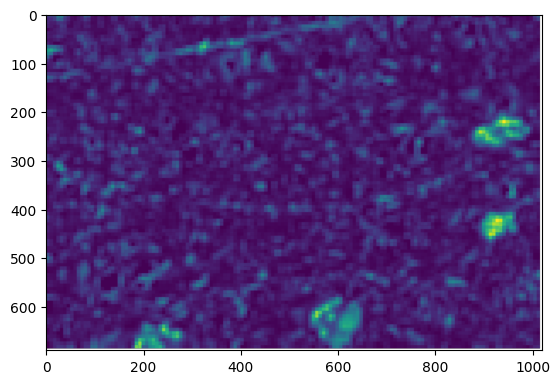

In [28]:
# plot the heatmap
plt.imshow(heatmap)

In [29]:
# build the detection mask, that has the same size of the test image
# each pixel in the mask has value 1 if the corresponding patch has been
# detected as anomalous, otherwise it has value 0
mask = np.zeros(img_test.shape)
mask[heatmap > threshold] = 1


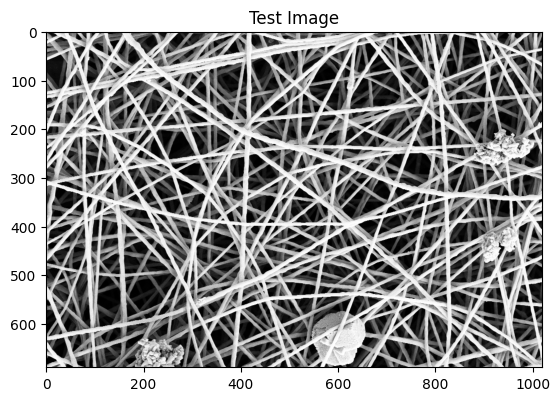

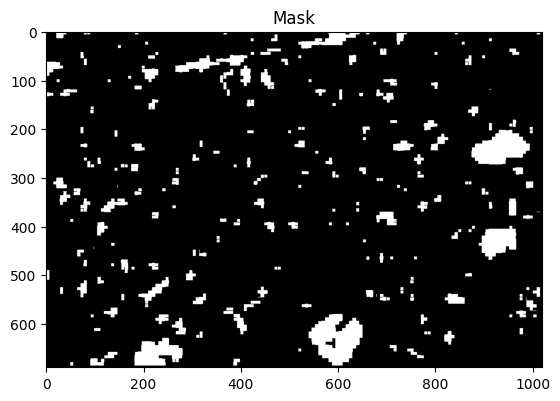

In [30]:
## show the results
plt.figure(3), plt.imshow(img_test, cmap='gray'), plt.title('Test Image')
plt.figure(4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
plt.show()

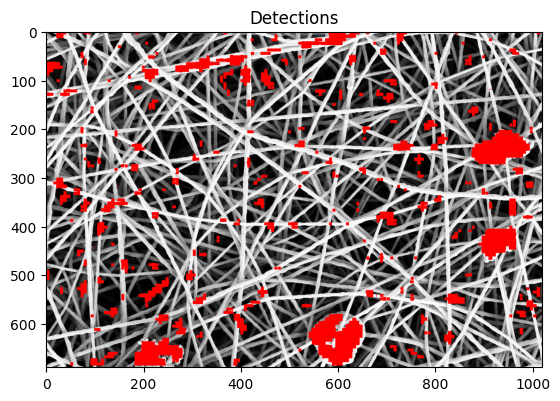

In [31]:
# combine the mask and the test image
img_color = np.zeros([img_test.shape[0], img_test.shape[1], 3])
img_temp = img_test.copy()
img_temp[mask > 0] = 1
img_color[:,:,0] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,1] = img_temp
img_temp = img_test.copy()
img_temp[mask > 0] = 0
img_color[:,:,2] = img_temp

plt.figure(5), plt.imshow(img_color), plt.title('Detections')
plt.show()